In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy_financial as npf
from IPython.display import display

**Обозначения:** \
**1) price - цена за одну упаковку\
2) expected_demand - ожидаемый спрос на печеньки\
3) std - стандартное отклонение\
4) cost - издержки на одну упаковку печенек\
5) cookies_per_day - кол-во выпекаемых упаковок печенек в день**

In [2]:
price = 50 
mean = 2500
cookies_per_day = 12
std = 500 
cost = 30
discount = 15

# Часть 1 (std=500)

**У нас есть мат ожидание и стандартное отклонение, найдем mu и sigma, чтобы затем подставить в np.random.lognormal**

In [3]:
mu = np.log(mean) - 0.5 * np.log(1 + (std ** 2) / (mean ** 2))
sigma = np.sqrt(np.log(std ** 2 / mean ** 2 + 1))


**Построим график смоделированного спроса, чтобы посмотреть как он будет выглядеть, а также посчитаем 5 и 95 перцентили и нанесем на график - между ними будет располагаться 90% всех значений.**

Количество значений между 5 и 95 перцентилем: 90000


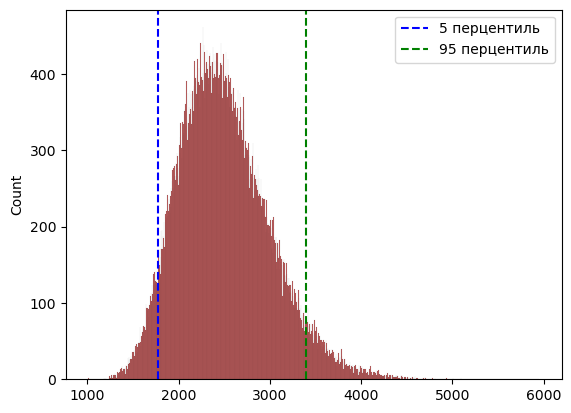

In [4]:
np.random.seed(42)
n = 100000
distribution = np.random.lognormal(mu, sigma, size=n)
percentile_5 = np.percentile(distribution, 5)
percentile_95 = np.percentile(distribution, 95)
count_between = np.sum((distribution >= percentile_5) & (distribution <= percentile_95))
print("Количество значений между 5 и 95 перцентилем:", count_between)
sns.histplot(distribution, bins=1000, color='brown')
plt.axvline(x=percentile_5, color='blue', linestyle='--', label='5 перцентиль')
plt.axvline(x=percentile_95, color='g', linestyle='--', label='95 перцентиль')
plt.legend();

X_left = np.ceil(percentile_5).astype(int)
X_right = np.ceil(percentile_95).astype(int)

**Применим метод Монте-карло. При этом стоит учесть, что спрос в нашем случае - дискретная величина, а np.random.lognormal будет генерировать величины типа float. Округлять до int нельзя, так как округление к ближайшему целому значению может привести к искажению логнормального распределения, поскольку это может изменить форму распределения и его параметры. Было принято решение округлять значения вверх - это помогает сохранить свойства логнормального распределения спроса и обеспечивает более точное моделирование реальных сценариев потребительского спроса.**

**Также за интервал цикла возьмем посчитанные ранее 5 и 95 перцентили и округлим их до целого также вверх.**

In [5]:
%%time

np.random.seed(42)

max_mean_profit = 0
max_median_profit = 0
optimal_mean = 0
optimal_median = 0
list_median_profit = []
list_mean_profit = []

for amount_cookies in range(X_left, X_right): # Пробегаемся по возможным значениям нашего предложения
    
    demand = np.random.lognormal(mu, sigma, size=n) # Генерируем спрос
    rounded_demand = np.ceil(demand) # Округляем спрос вверх
    
    sales = np.minimum(amount_cookies, rounded_demand) # если произвели меньше чем спрос то запишется это, иначе запишется спрос
    overproduction = np.maximum(0, amount_cookies-rounded_demand) # если произвели сами больше чем спрос то это запишется в перепроизводство, иначе 0 
    profit = price*sales - cost*amount_cookies + discount*overproduction # если перепроизводство=0 то последнее произведение = 0

    mean_profit = np.mean(profit)
    median_profit = np.median(profit)

    # будем добавлять в один список все средние значения прибыли, в другой - все медианные
    list_mean_profit.append(mean_profit)
    list_median_profit.append(median_profit)

    if mean_profit > max_mean_profit:
        max_mean_profit = mean_profit
        optimal_mean = amount_cookies
        
    if median_profit > max_median_profit:
        max_median_profit = median_profit
        optimal_median = amount_cookies



print(f'Максимально возможная средняя прибыль: {max_mean_profit}, соответствующая итерация: {optimal_mean}')
print(f'Максимально возможная медианная прибыль: {max_median_profit}, соответствующая итерация: {optimal_median}')

Максимально возможная средняя прибыль: 43201.61835, соответствующая итерация: 2567
Максимально возможная медианная прибыль: 49080.0, соответствующая итерация: 2454
CPU times: total: 6.48 s
Wall time: 6.61 s


**Посмотрим на среднюю и медианную прибыль:**

In [6]:
print(f'Средняя прибыль: {np.mean(np.array(list_mean_profit))}')
print(f'Медианная прибыль: {np.median(np.array(list_median_profit))}')

Средняя прибыль: 40441.240839134436
Медианная прибыль: 42075.0


**Теперь провизуализируем полученные результаты:**

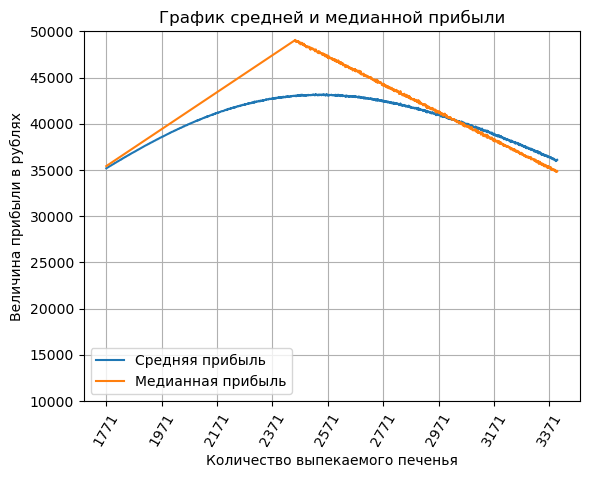

In [7]:
plt.plot(range(X_left, X_right), list_mean_profit, label='Средняя прибыль')
plt.plot(range(X_left, X_right), list_median_profit, label='Медианная прибыль')
plt.title('График средней и медианной прибыли')
plt.xlabel('Количество выпекаемого печенья')
plt.ylabel('Величина прибыли в рублях')
plt.xticks(range(X_left, X_right, 200), rotation=60)
plt.yticks(range(10000, 50001, 5000))
plt.grid(True)
plt.legend()
plt.show()

**Таким образом ответ на вопрос 1.1:\
Средняя прибыль: 40441.240839134436\
Медианная прибыль: 42075.03**

**Теперь узнаем сколько печенья нужно печь ежедневно, чтобы достигать максимальной прибыли.\
В качестве оптимального количества печенья будет выбрано то, которое приносит максимальную медианную прибыль по всем мультивселенным.\
\
Я взял именно медианную прибыль, так как средняя прибыль будет смещенная, а медианная нет.\
Это уже было посчитано в цикле - "Максимально возможная медианная прибыль: 49080.0, соответствующая итерация: 2454".\
Таким образом, оптимальный заказ печенья - 2454 упаковок, что соответствует 12 * 2454 = 29448 печенек в день.\
\
Ответ на вопрос 1.2: 29448 печенек в день.**

In [8]:
12 * 2454

29448

**Какую сумму в среднем фирма теряет на избытке и на недостатке печенья при оптимальном заказе?**

In [9]:
np.random.seed(42)

demand = np.random.lognormal(mu, sigma, size=n) # Генерируем спрос
rounded_demand = np.ceil(demand) # Округляем спрос вверх

rounded_demand[rounded_demand > optimal_mean] # спрос > выпуска, произвели меньше чем надо 
rounded_demand[rounded_demand > optimal_mean] - optimal_mean # вычли то сколько мы произвели чтобы найти дельту - недопроизводство
(rounded_demand[rounded_demand > optimal_mean] - optimal_mean) * price # столько могли бы получить выручки дополнительно 
underproduction = (rounded_demand[rounded_demand > optimal_mean] - optimal_mean) * price - (rounded_demand[rounded_demand > optimal_mean] - optimal_mean) * cost # столько могли бы получить Прибыли дополнительно
print(f'Средние потери прибыли от недопроизводства: {np.mean(underproduction)}') # Столько в среднем теряем прибыли от недопроизводства

rounded_demand[optimal_mean > rounded_demand] # массив, где поизводство оказалось больше чем спрос 
optimal_mean - rounded_demand[optimal_mean > rounded_demand] # Из выпуска вычесть этот спрос - получили излишек производства то есть непроданные печеньки
(optimal_mean - rounded_demand[optimal_mean > rounded_demand]) * cost # Затраты на эти непроданные печеньки

Overproduction = (optimal_mean - rounded_demand[optimal_mean > rounded_demand]) * cost - (optimal_mean - rounded_demand[optimal_mean > rounded_demand]) * discount # Общие потери перепроизводства
print(f'Средние потери прибыли от перепроизводства: {np.mean(Overproduction)}') 

Средние потери прибыли от недопроизводства: 8273.531011836205
Средние потери прибыли от перепроизводства: 5956.198853160575


**Ответ на вопрос 1.3:\
Средние потери прибыли от недопроизводства: 8273.531011836205\
Средние потери прибыли от перепроизводства: 5956.1988531605752**

**--------------------------------------------------------------------------------------------------------------**

# Часть 2 (std=1000)

**Теперь проделаем те же три шага, но теперь std = 1000**

In [10]:
std = 1000

mu = np.log(mean) - 0.5 * np.log(1 + (std ** 2) / (mean ** 2))
sigma = np.sqrt(np.log(std ** 2 / mean ** 2 + 1))

Количество значений между 5 и 95 перцентилем: 90000


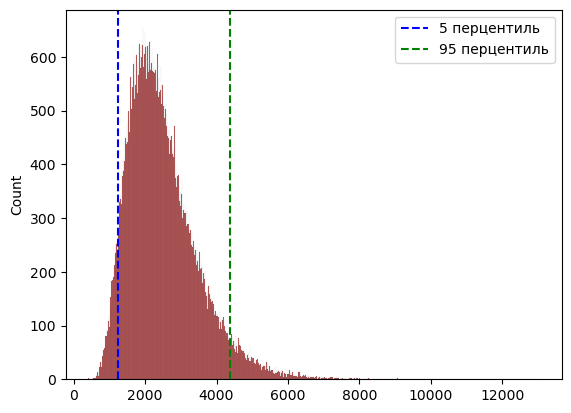

In [11]:
np.random.seed(42)
n = 100000
distribution = np.random.lognormal(mu, sigma, size=n)
percentile_5 = np.percentile(distribution, 5)
percentile_95 = np.percentile(distribution, 95)
count_between = np.sum((distribution >= percentile_5) & (distribution <= percentile_95))
print("Количество значений между 5 и 95 перцентилем:", count_between)
sns.histplot(distribution, bins=1000, color='brown')
plt.axvline(x=percentile_5, color='blue', linestyle='--', label='5 перцентиль')
plt.axvline(x=percentile_95, color='g', linestyle='--', label='95 перцентиль')
plt.legend();

X_left = np.ceil(percentile_5).astype(int)
X_right = np.ceil(percentile_95).astype(int)

In [12]:
%%time

np.random.seed(42)

max_mean_profit = 0
max_median_profit = 0
optimal_mean = 0
optimal_median = 0
list_median_profit = []
list_mean_profit = []

for amount_cookies in range(X_left, X_right): # Пробегаемся по возможным значениям нашего предложения
    
    demand = np.random.lognormal(mu, sigma, size=n) # Генерируем спрос
    rounded_demand = np.ceil(demand) # Округляем спрос вверх
    
    sales = np.minimum(amount_cookies, rounded_demand) # если произвели меньше чем спрос то запишется это, иначе запишется спрос
    overproduction = np.maximum(0, amount_cookies-rounded_demand) # если произвели сами больше чем спрос то это запишется в перепроизводство, иначе 0 
    profit = price*sales - cost*amount_cookies + discount*overproduction # если перепроизводство=0 то последнее произведение = 0

    mean_profit = np.mean(profit)
    median_profit = np.median(profit)

    # будем добавлять в один список все средние значения прибыли, в другой - все медианные
    list_mean_profit.append(mean_profit)
    list_median_profit.append(median_profit)

    if mean_profit > max_mean_profit:
        max_mean_profit = mean_profit
        optimal_mean = amount_cookies
        
    if median_profit > max_median_profit:
        max_median_profit = median_profit
        optimal_median = amount_cookies



print(f'Максимально возможная средняя прибыль: {max_mean_profit}, соответствующая итерация: {optimal_mean}')
print(f'Максимально возможная медианная прибыль: {max_median_profit}, соответствующая итерация: {optimal_median}')

Максимально возможная средняя прибыль: 36739.0297, соответствующая итерация: 2462
Максимально возможная медианная прибыль: 46560.0, соответствующая итерация: 2328
CPU times: total: 12.7 s
Wall time: 12.8 s


**Видим, что как среднее, так и медианное значение нашей возможной прибыли упали.**

In [13]:
print(f'Средняя прибыль: {np.mean(np.array(list_mean_profit))}')
print(f'Медианная прибыль: {np.median(np.array(list_median_profit))}')

Средняя прибыль: 31303.884102665823
Медианная прибыль: 32920.0


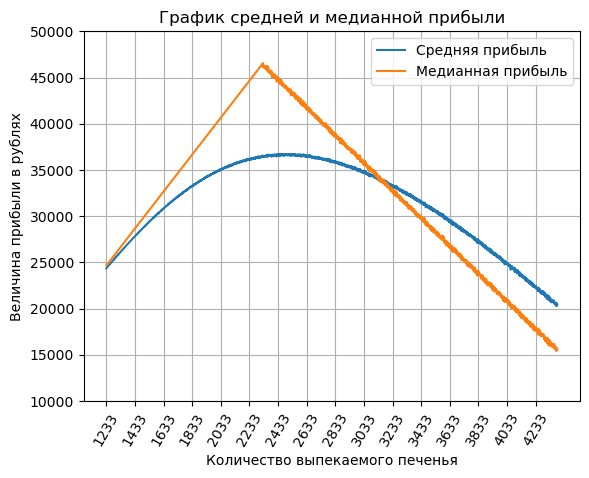

In [14]:
plt.plot(range(X_left, X_right), list_mean_profit, label='Средняя прибыль')
plt.plot(range(X_left, X_right), list_median_profit, label='Медианная прибыль')
plt.title('График средней и медианной прибыли')
plt.xlabel('Количество выпекаемого печенья')
plt.ylabel('Величина прибыли в рублях')
plt.xticks(range(X_left, X_right, 200), rotation=60)
plt.yticks(range(10000, 50001, 5000))
plt.grid(True)
plt.legend()
plt.show()

In [15]:
np.random.seed(42)

demand = np.random.lognormal(mu, sigma, size=n) # Генерируем спрос
rounded_demand = np.ceil(demand) # Округляем спрос вверх

rounded_demand[rounded_demand > optimal_mean] # спрос > выпуска, произвели меньше чем надо 
rounded_demand[rounded_demand > optimal_mean] - optimal_mean # вычли то сколько мы произвели чтобы найти дельту - недопроизводство
(rounded_demand[rounded_demand > optimal_mean] - optimal_mean) * price # столько могли бы получить выручки дополнительно 
underproduction = (rounded_demand[rounded_demand > optimal_mean] - optimal_mean) * price - (rounded_demand[rounded_demand > optimal_mean] - optimal_mean) * cost # столько могли бы получить Прибыли дополнительно
print(f'Средние потери прибыли от недопроизводства: {np.mean(underproduction)}') # Столько в среднем теряем прибыли от недопроизводства

rounded_demand[optimal_mean > rounded_demand] # массив, где поизводство оказалось больше чем спрос 
optimal_mean - rounded_demand[optimal_mean > rounded_demand] # Из выпуска вычесть этот спрос - получили излишек производства то есть непроданные печеньки
(optimal_mean - rounded_demand[optimal_mean > rounded_demand]) * cost # Затраты на эти непроданные печеньки

Overproduction = (optimal_mean - rounded_demand[optimal_mean > rounded_demand]) * cost - (optimal_mean - rounded_demand[optimal_mean > rounded_demand]) * discount # Общие потери перепроизводства
print(f'Средние потери прибыли от перепроизводства: {np.mean(Overproduction)}') 


Средние потери прибыли от недопроизводства: 18196.29966981669
Средние потери прибыли от перепроизводства: 9630.61662533231


**Ответы: \
Средняя прибыль: 31303.884102665823\
Медианная прибыль: 32920.\
2328*12 = 27936 печенек - оптимальный заказ\
Средние потери прибыли от недопроизводства: 18196.29966981669\
Средние потери прибыли от перепроизводства: 9630.616625332310**

In [16]:
2328*12


27936